## Import libraries

In [ ]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.container import Sequential
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
from tqdm import tqdm, tqdm_notebook

from torchvision import transforms

## Load dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
!unrar x /content/gdrive/MyDrive/Colab_Notebooks/PH2Dataset.rar

In [ ]:
np.random.seed(2022)
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
#resize imgaes so that they have one size
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

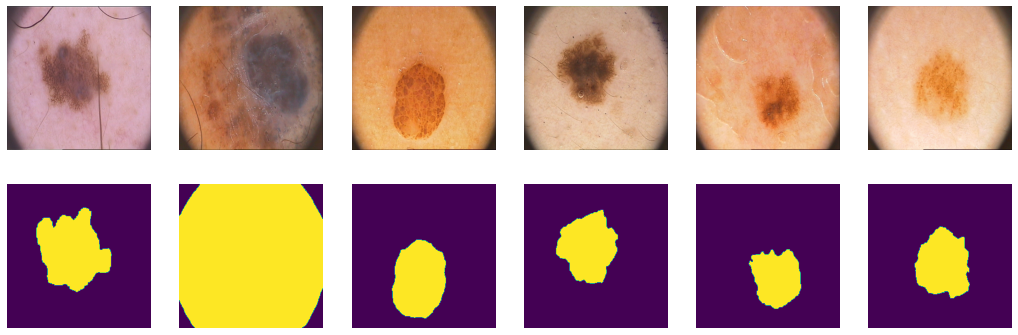

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Divide our 200 images by 100/50/50 for training, validation and test respectively

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))

## PyTorch DataLoader

In [ ]:
batch_size = 8
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
len(next(iter(data_ts))[0])

8

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Realization of SegNet

:-----------------------------------------------------------------------------------------
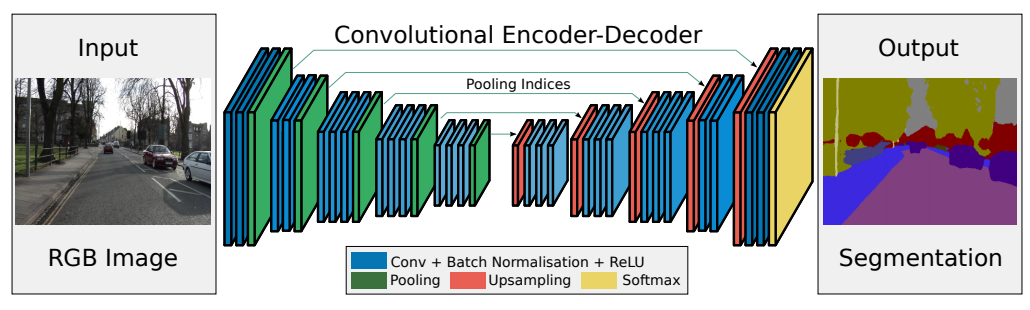

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
rcParams['figure.figsize'] = (15,4)

In [ ]:
vgg16 = models.vgg16(pretrained=True)

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, ind0 = F.max_pool2d(e0, kernel_size=2, stride=2, return_indices=True)
        e1 = self.enc_conv1(e0)
        e1, ind1 = F.max_pool2d(e1, kernel_size=2, stride=2, return_indices=True)
        e2 = self.enc_conv2(e1)
        e2, ind2 = F.max_pool2d(e2, kernel_size=2, stride=2, return_indices=True)
        e3 = self.enc_conv3(e2)
        e3, ind3 = F.max_pool2d(e3, kernel_size=2, stride=2, return_indices=True)
        e4 = self.enc_conv4(e3)
        e4, ind4 = F.max_pool2d(e4, kernel_size=2, stride=2, return_indices=True)
        # decoder
        d0 = F.max_unpool2d(e4, ind4, kernel_size=2, stride=2)
        d0 = self.dec_conv0(d0)
        d1 = F.max_unpool2d(d0, ind3, kernel_size=2, stride=2)
        d1 = self.dec_conv1(d1)
        d2 = F.max_unpool2d(d1, ind2, kernel_size=2, stride=2)
        d2 = self.dec_conv2(d2)
        d3 = F.max_unpool2d(d2, ind1, kernel_size=2, stride=2)
        d3 = self.dec_conv3(d3)
        d4 = F.max_unpool2d(d3, ind0, kernel_size=2, stride=2)
        d4 = self.dec_conv4(d4)
        #d3_softmax = F.sigmoid(d3)  # no activation
        return d4

## Metrics


$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded 

## Loss functions

Binary cross entropy for binary segmentation:
$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Due to the fact that $\lim_{x\rightarrow0}\log(x)=\infty$, 
the equivalent function is applied:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    batch_size = y_real.shape[0]
    y_real = y_real.view(batch_size, -1)
    y_pred = y_pred.view(batch_size, -1)
    result = (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).mean(-1)
    return result.mean() # average over all samples in a batch

## Functions for training the model 

In [ ]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val):
    """Trains the model. Returns trained model and dict with train and val losses"""
    losses = {'train': [], 'val': []}
    metrics = {'train': [], 'val': []}
    lr_scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
    for epoch in range(epochs):
        print('Epoch {}/{}:'.format(epoch, epochs - 1), flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = data_tr
                model.train()
            else:
                dataloader = data_val
                model.eval()
            tic = time()
            running_loss = 0.
            running_iou = 0.
            for X_batch, Y_batch in tqdm(dataloader, leave=False, desc=f"{phase} iter:"):
                X_batch = X_batch.to(device)# data to device
                Y_batch = Y_batch.to(device)
                opt.zero_grad() # set parameter gradients to zero
                # forward
                with torch.set_grad_enabled(phase=='train'):
                    Y_pred = model(X_batch)
                    #print(Y_pred.shape)
                    loss = loss_fn(Y_batch, Y_pred)# forward-pass
                    if phase == 'train':
                        loss.backward()  # backward-pass
                        opt.step()  # update weights
                # calculate loss to show the user
                running_loss += loss.item()
                # calculate metrics 
                Y_pred = torch.sigmoid(Y_pred)
                Y_pred = (Y_pred > 0.5).float()
                running_iou += metric(Y_pred, Y_batch).mean().item()
            if phase == 'train':
                lr_scheduler.step()
            epoch_loss = running_loss / len(dataloader)
            epoch_iou = running_iou / len(dataloader)
            toc = time()
            losses[phase].append(epoch_loss)
            metrics[phase].append(epoch_iou)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print('{} IoU: {:.4f}'.format(phase, epoch_iou))
    return losses, metrics

In [ ]:
def picturize(model, loss_fn, epochs, data_val):
    """Draws the result on the batch samples"""
    for epoch in range(epochs):
        X_val, Y_val = next(iter(data_val))
        X_val = X_val.to(device)
        model.eval()
        with torch.no_grad():
            Y_hat = model(X_val).detach().cpu() # detach and put into cpu
            loss_val = loss_fn(Y_val, Y_hat)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, 6, k+7)
            Y = torch.sigmoid(Y_hat[k, 0])
            Y = (Y > 0.5).type(torch.uint8).float() # 1 if value is higher than 0.5, 0 otherwise
            plt.imshow(Y, cmap='gray')
            #print(Y_hat.shape)
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - : %f' % (epoch+1, epochs, loss_val))
        plt.show()

## Functions for inference

In [ ]:
def predict(model, data):
    """Makes segmentation on the test data"""
    Y_pred = []
    model.eval()
    for X_batch, _ in data:
        with torch.no_grad():
            X_batch = X_batch.to(device)
            Y_pred.append(model(X_batch).detach().cpu())
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    """Evaluate the quality of the trained model"""
    model.eval() # testing mode
    scores = 0
    for X_batch, Y_batch in data:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_pred = model(X_batch)
        Y_pred = torch.sigmoid(Y_pred)
        Y_pred = (Y_pred > 0.5).float()
        scores += metric(Y_pred, Y_batch).mean().item()
    return scores / len(data)

## Training the model

In [ ]:
model = SegNet().to(device)

In [ ]:
model

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc_conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReL

In [ ]:
max_epochs = 20
#loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.00001)
#optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=1e-3, weight_decay=0.00001)
losses_segnet_bse, metrics_segnet_bse = train(model, optimizer, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

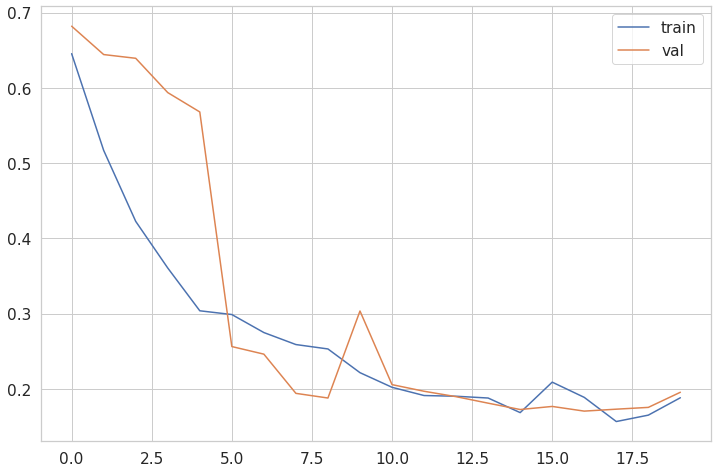

In [ ]:
# losses
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses_segnet_bse['train'], label="train")
plt.plot(losses_segnet_bse['val'], label="val")
plt.legend()
plt.show()

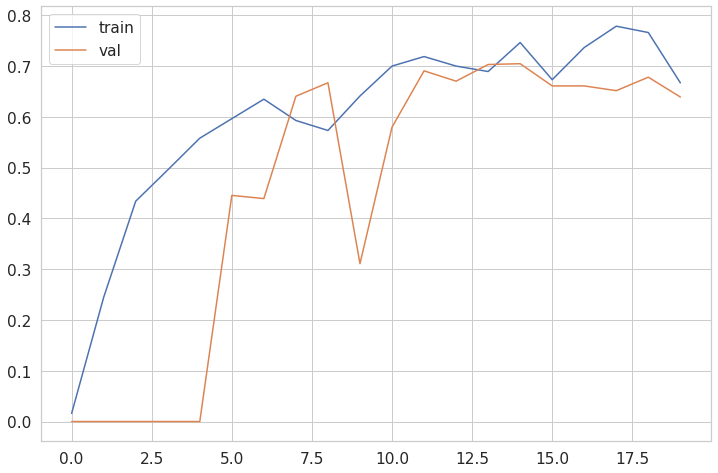

In [ ]:
# metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_segnet_bse['train'], label="train")
plt.plot(metrics_segnet_bse['val'], label="val")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


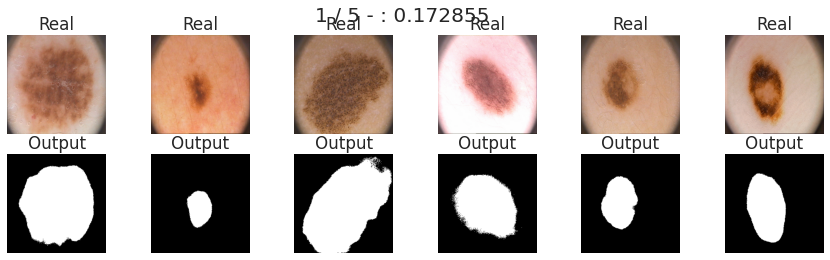

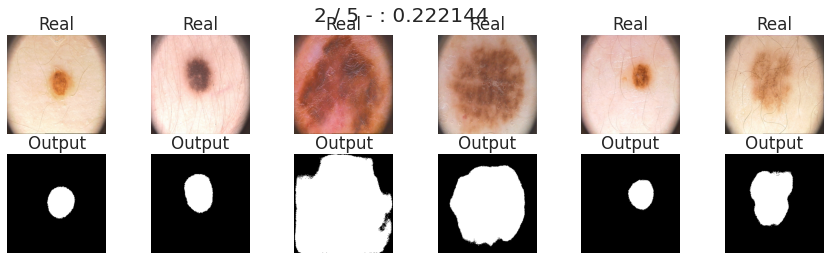

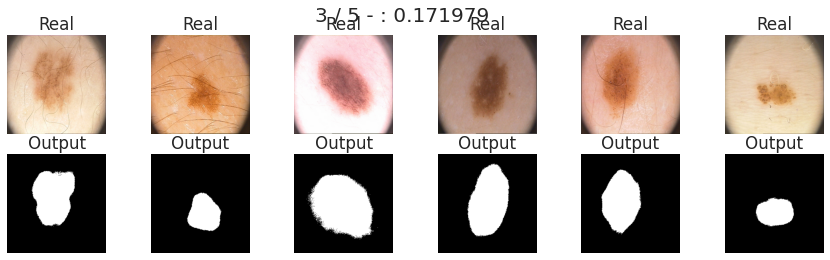

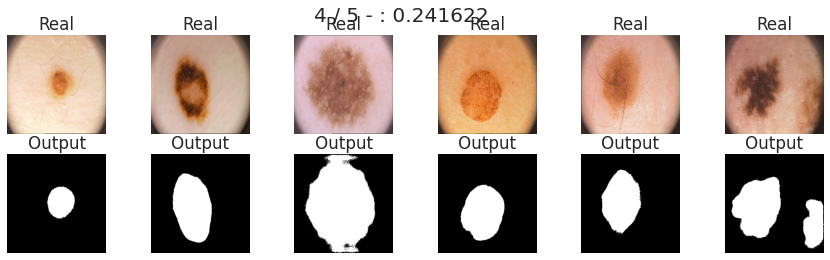

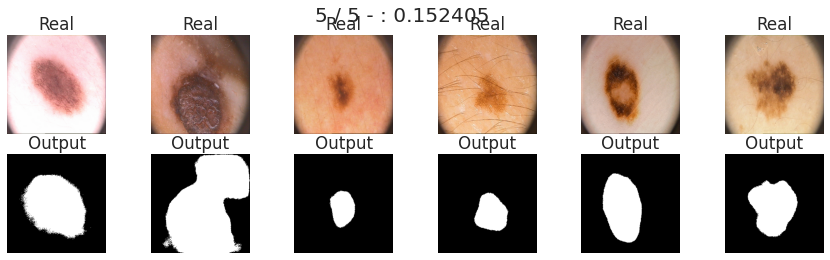

In [ ]:
# result on the validation data
picturize(model, bce_loss, 5, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.690625011920929

**SegNet with BСELoss on the test data**

In [ ]:
score_model(model, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7343750298023224

## Additional loss functions

1. Dice coefficient: 

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

In [ ]:
def dice_loss(y_real, y_pred):
    smooth = 1e-8
    batch_size = y_pred.shape[0]
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.view(batch_size, -1)
    y_pred = y_pred.view(batch_size, -1)
    num = (2. * y_real * y_pred).sum(-1) # sum over batch
    den = (y_real + y_pred).sum(-1)
    res = 1 - ((num + smooth)/(den + smooth)).mean()
    return res

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 20
optimizer = optim.Adam(model_dice.parameters(), lr=1e-4, weight_decay=0.00001)
losses_segnet_dice, metrics_segnet_dice = train(model_dice, optimizer, dice_loss, iou_pytorch, max_epochs, data_tr, data_val)

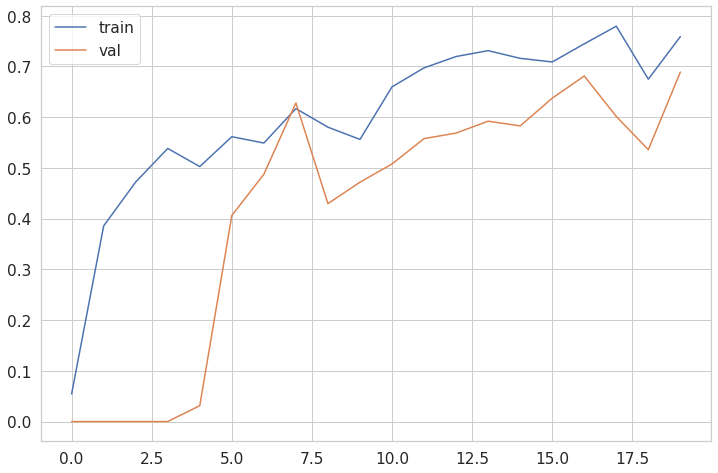

In [ ]:
# metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_segnet_dice['train'], label="train")
plt.plot(metrics_segnet_dice['val'], label="val")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


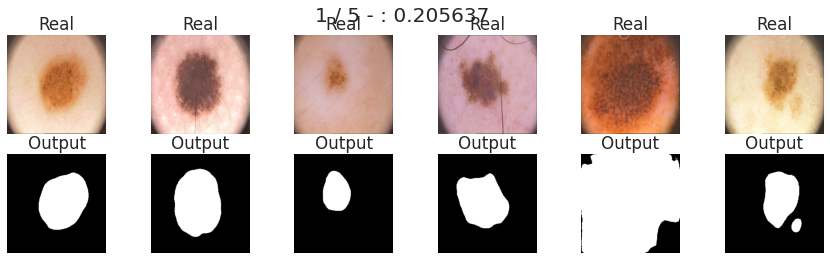

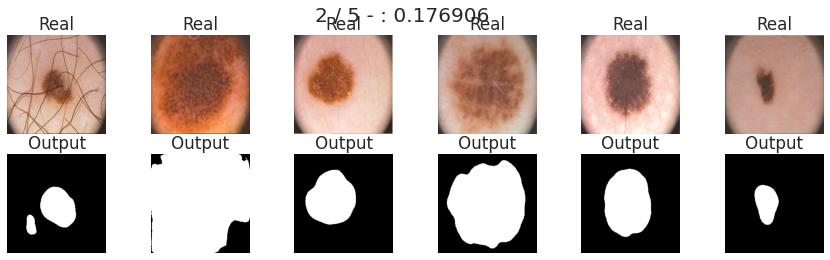

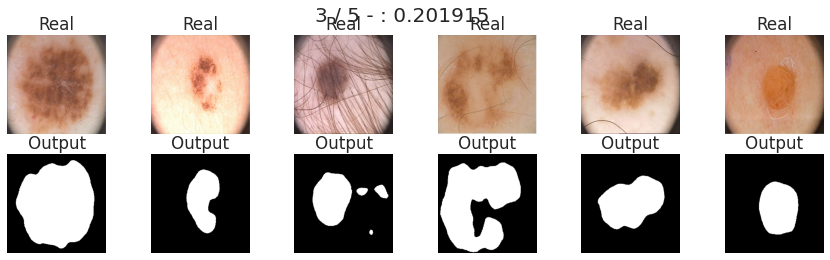

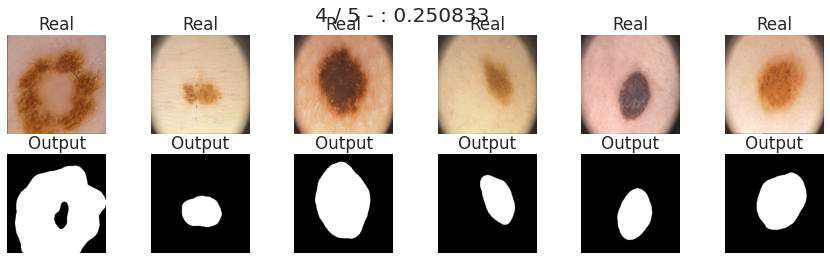

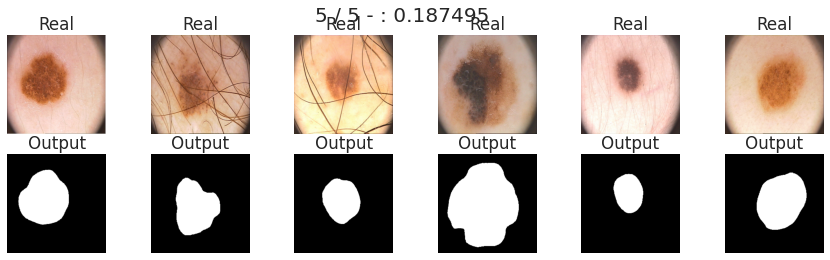

In [ ]:
picturize(model_dice, bce_loss, 5, data_val)

**SEGNET with DICE loss on the test data**

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.721875011920929

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    batch_size = y_real.shape[0]
    y_pred =  torch.sigmoid(y_pred)
    y_pred = y_pred.view(batch_size, -1)
    y_real = y_real.view(batch_size, -1)
    result = (-((1 - y_pred) ** gamma * y_real * torch.log(y_pred) +  y_pred ** gamma * (1 - y_real) * torch.log(1 - y_pred))).mean(-1)
    return result.mean()

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
optimizer = optim.Adam(model_focal.parameters(), lr=1e-4, weight_decay=0.00001)
losses_segnet_focal, metrics_segnet_focal = train(model_focal, optimizer, focal_loss, iou_pytorch, max_epochs, data_tr, data_val)

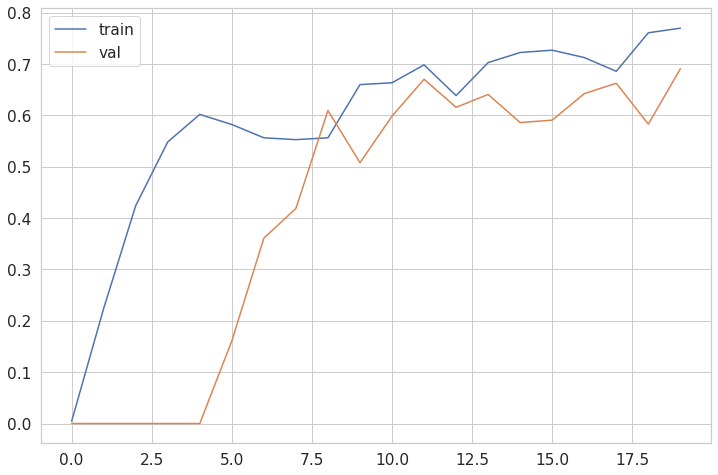

In [ ]:
#metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_segnet_focal['train'], label="train")
plt.plot(metrics_segnet_focal['val'], label="val")
plt.legend()
plt.show()

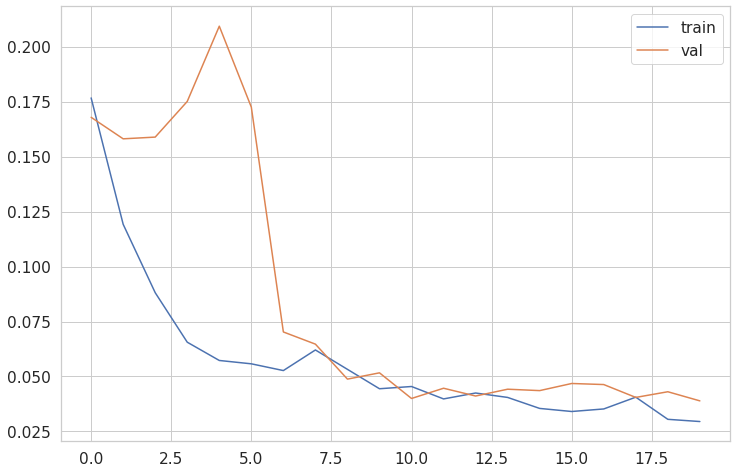

In [ ]:
#losses
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses_segnet_focal['train'], label="train")
plt.plot(losses_segnet_focal['val'], label="val")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


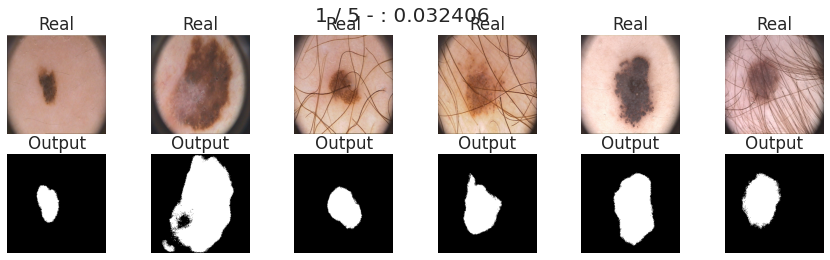

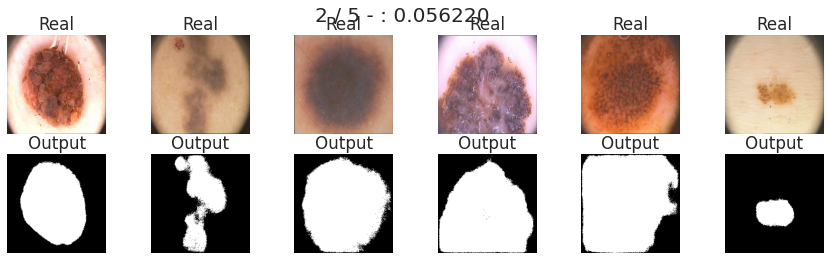

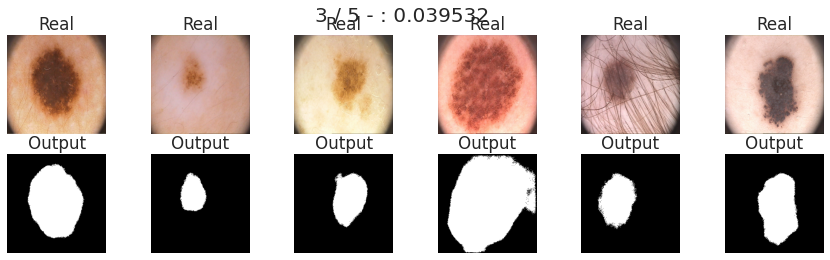

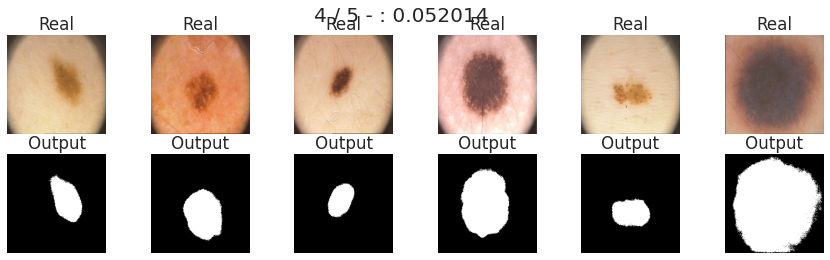

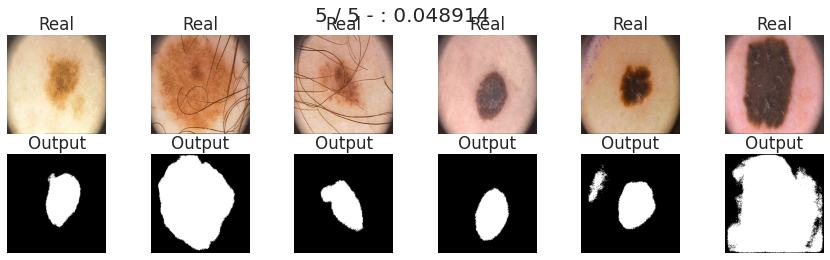

In [ ]:
picturize(model_focal, focal_loss, 5, data_val)

**SegNet with Focal loss on the test data**

In [ ]:
score_model(model_focal, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6578125059604645

[**3. Tverskiy loss:**](https://arxiv.org/abs/1706.05721)




**TVERSKY LOSS** \
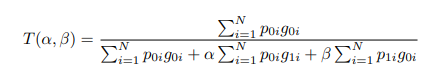

In [ ]:
alpha = 0.3
beta = 0.7
def tversky_loss(y_real, y_pred, alpha=alpha, beta=beta, smooth=1e-8):
    batch_size = y_pred.shape[0]
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.view(batch_size, -1)
    y_pred = y_pred.view(batch_size, -1)
    TP = (y_real * y_pred).sum(-1) # true positive
    FP = (y_pred * (1 - y_real)).sum(-1) # false positive
    FN = ((1 - y_pred) * y_real).sum(-1) # false negative
    T = TP / (TP + alpha * FP + beta * FN)
    return 1 - T.mean() # average over all samples in a batch

In [ ]:
model_t = SegNet().to(device)

In [ ]:
model_t = SegNet().to(device)
max_epochs = 20
optimizer = optim.Adam(model_t.parameters(), lr=1e-4, weight_decay=0.00001)
losses_segnet_t, metrics_segnet_t  = train(model_t, optimizer, tversky_loss, iou_pytorch, max_epochs, data_tr, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


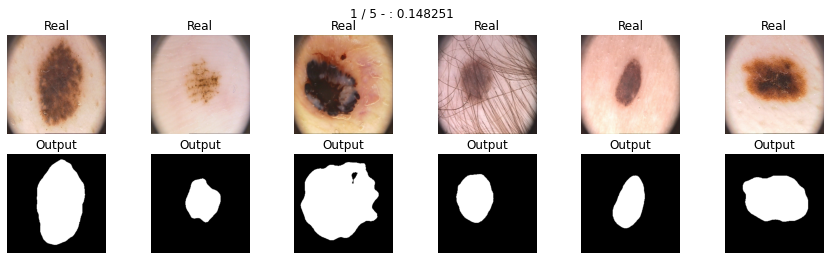

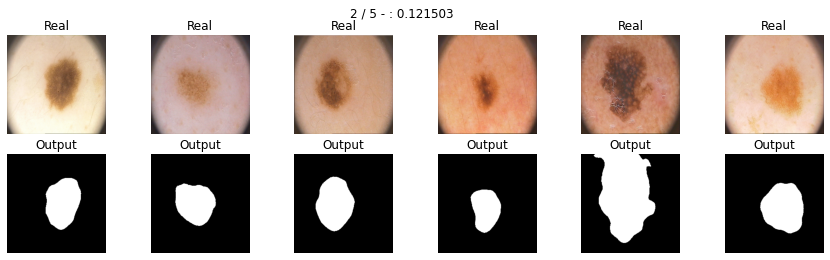

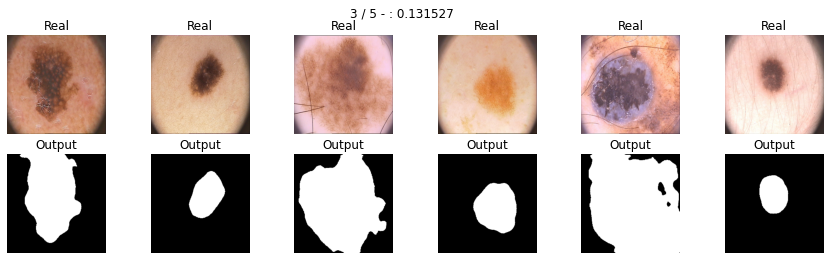

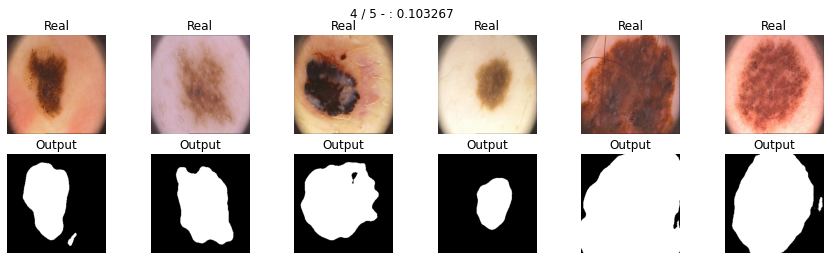

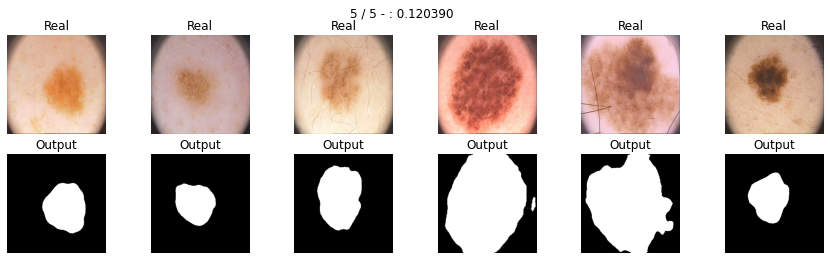

In [ ]:
picturize(model_t, tversky_loss, 5, data_val)

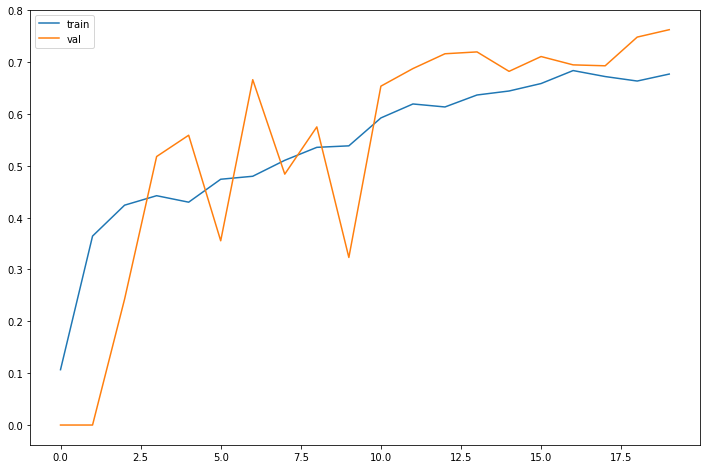

In [ ]:
# metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_segnet_t['train'], label="train")
plt.plot(metrics_segnet_t['val'], label="val")
plt.legend()
plt.show()

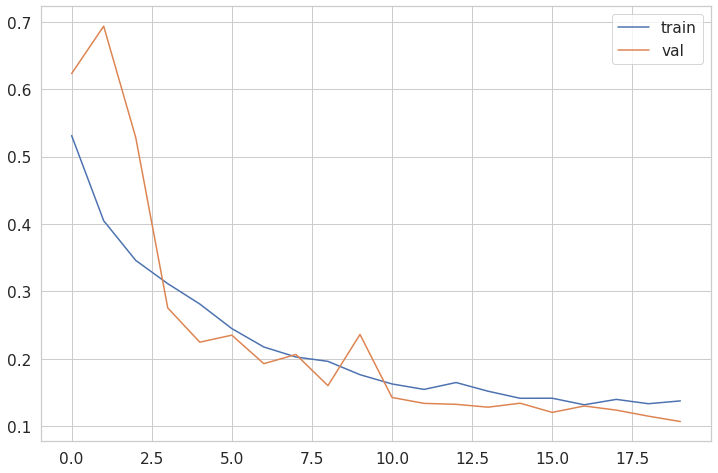

In [ ]:
# losses
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses_segnet_t['train'], label="train")
plt.plot(losses_segnet_t['val'], label="val")
plt.legend()
plt.show()

**SegNet with Tversky Loss on the test data**

In [ ]:
score_model(model_t, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7000000051089695

**4. Jaccard loss:**

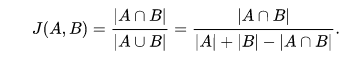

In [ ]:
def jaccard_loss(y_real, y_pred, smooth=1e-8):
    batch_size = y_pred.shape[0]
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.view(batch_size, -1)
    y_pred = y_pred.view(batch_size, -1)
    intersection = (y_real * y_pred).sum(-1)
    union = y_real.sum(-1) + y_pred.sum(-1) - intersection
    result = (intersection + smooth)/(union + smooth)
    return 1 - result.mean()

In [ ]:
model_jaccard = SegNet().to(device)
max_epochs = 20
optimizer = optim.Adam(model_jaccard.parameters(), lr=1e-4, weight_decay=0.00001)
losses_segnet_jaccard, metrics_segnet_jaccard  = train(model_jaccard, optimizer, jaccard_loss, iou_pytorch, max_epochs, data_tr, data_val)

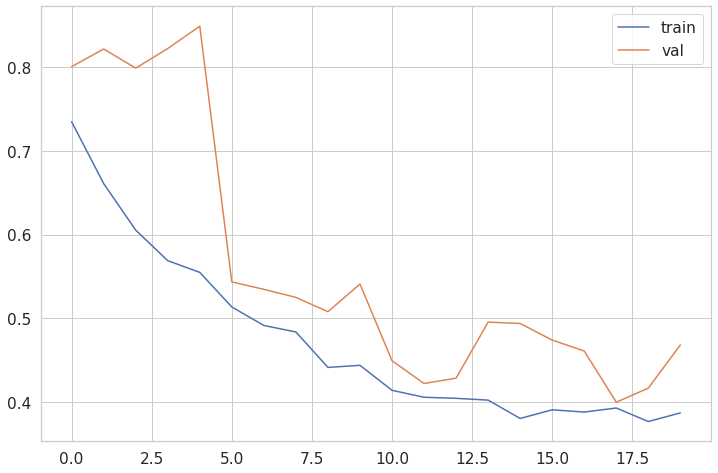

In [ ]:
# losses
plt.figure(figsize=(12, 8))
plt.plot(losses_segnet_jaccard['train'], label="train")
plt.plot(losses_segnet_jaccard['val'], label="val")
plt.legend()
plt.show()

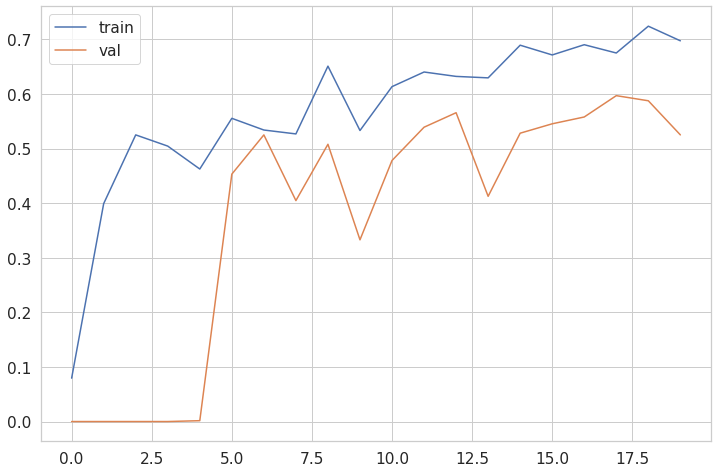

In [ ]:
# metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_segnet_jaccard['train'], label="train")
plt.plot(metrics_segnet_jaccard['val'], label="val")
plt.legend()
plt.show()

**SegNet with Jaccard Loss on the test data**

In [ ]:
score_model(model_jaccard, iou_pytorch, data_ts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.706250011920929

## Unet Realization

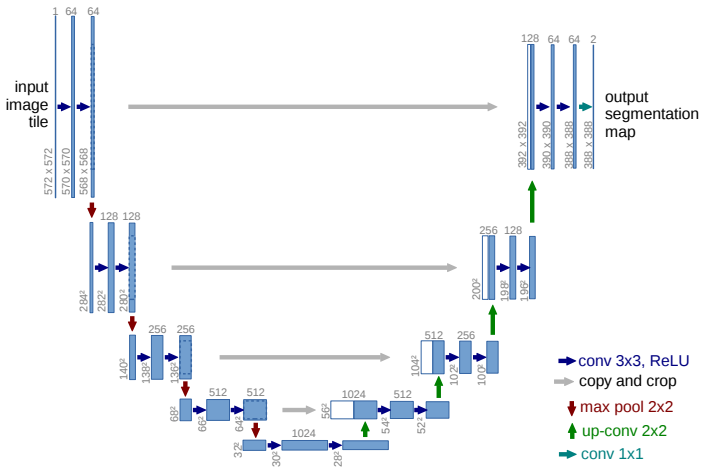

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(
            kernel_size=2, stride=2
        ) 
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.pool1 = nn.MaxPool2d(
            kernel_size=2, stride=2
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.pool2 = nn.MaxPool2d(
            kernel_size=2, stride=2
        ) 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.pool3 = nn.MaxPool2d(
            kernel_size=2, stride=2
        ) 
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size=32, mode='nearest')
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(size=64, mode='nearest')
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(size=128, mode='nearest')
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(size=256, mode='nearest')
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )
    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        #print(e0)
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))
        #print(e3.shape)

        # bottleneck
        b = self.bottleneck_conv(e3)
        #print(b.shape)

        # decoder
        d0 = self.upsample0(b)
        cropped_enc_2 = self.crop(self.enc_conv3(e2), d0)
        #print(self.enc_conv3(e2).shape)
        #print(d0.shape)
        #print((cropped_enc_2).shape)
        d0 = torch.cat((d0, cropped_enc_2), dim=1)
        #print(d0.shape)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        cropped_enc_1 = self.crop(self.enc_conv2(e1), d1)
        d1 = torch.cat((d1, cropped_enc_1), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        cropped_enc_0 = self.crop(self.enc_conv1(e0), d2)
        d2 = torch.cat((d2, cropped_enc_0), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        cropped_enc_input = self.crop(self.enc_conv0(x), d3)
        d3 = torch.cat((d3, cropped_enc_input), dim=1)
        d3 = self.dec_conv3(d3)
        return F.interpolate(d3, (256,256)) # make the size of the output tensor equal to the input
    def crop(self, encoder, x):
        H, W = x.shape[2], x.shape[3]
        encoder = transforms.CenterCrop((H, W))(encoder)
        return encoder

**UNET + BCELoss**

In [ ]:
unet_model = UNet().to(device)

In [ ]:
losses_unet_bce, metrics_unet_bce = train(unet_model, optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=0.00001), bce_loss, iou_pytorch, 20, data_tr, data_val)

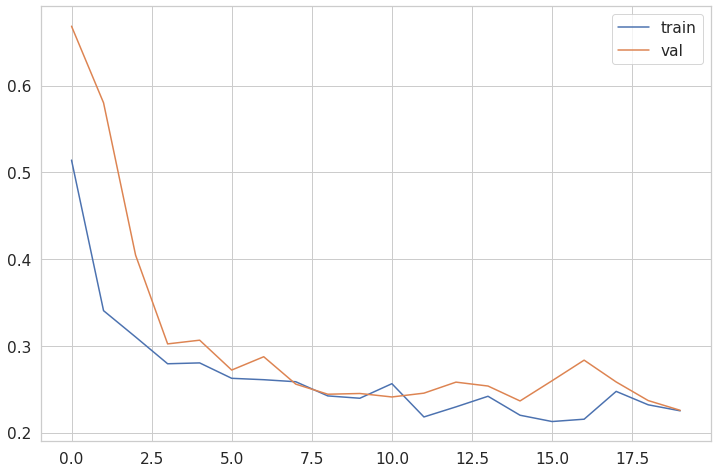

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_bce['train'], label="train")
plt.plot(losses_unet_bce['val'], label="val")
plt.legend()
plt.show()

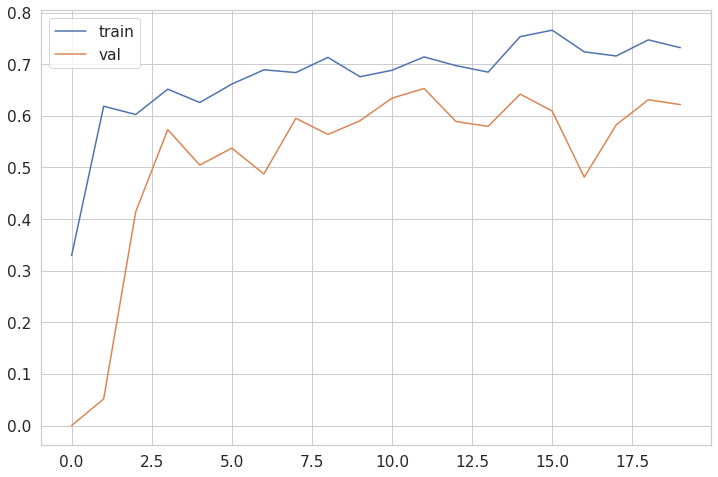

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_bce['train'], label="train")
plt.plot(metrics_unet_bce['val'], label="val")
plt.legend()
plt.show()

**UNET with BCE loss on the test data**

In [ ]:
score_model(unet_model, iou_pytorch, data_ts)

0.7421875298023224

**UNET + Dice Loss**

In [ ]:
unet_dice = UNet().to(device)
optimizer = optim.Adam(unet_dice.parameters(), lr=1e-4, weight_decay=0.00001)
losses_unet_dice, metrics_unet_dice = train(unet_dice, optimizer, dice_loss, iou_pytorch, 20, data_tr, data_val)

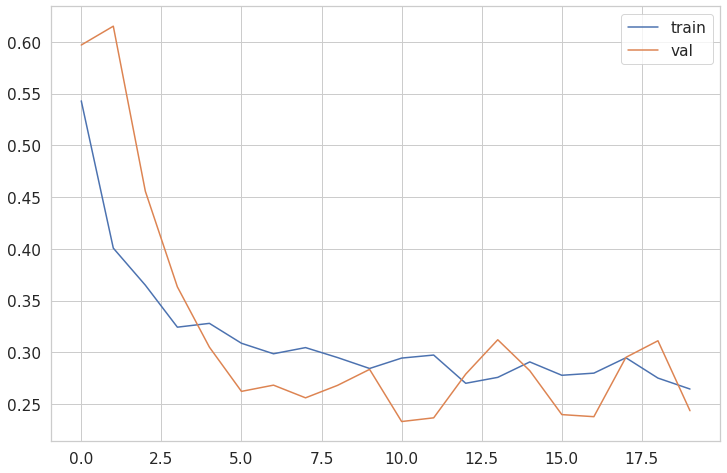

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_dice['train'], label="train")
plt.plot(losses_unet_dice['val'], label="val")
plt.legend()
plt.show()

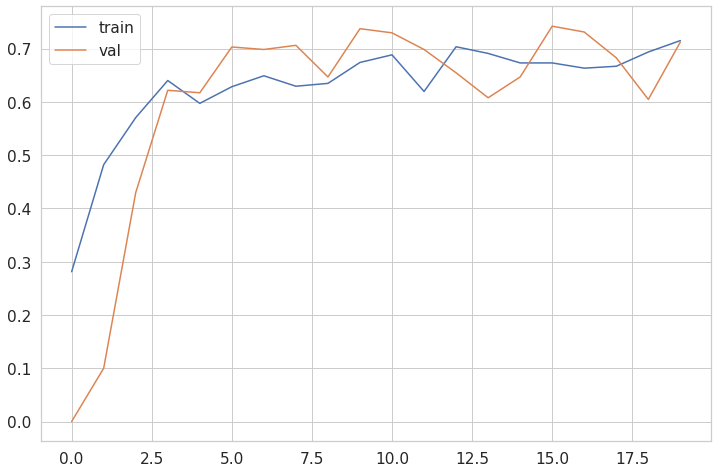

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_dice['train'], label="train")
plt.plot(metrics_unet_dice['val'], label="val")
plt.legend()
plt.show()

**UNET with Dice Loss on the test data**

In [ ]:
score_model(unet_dice, iou_pytorch, data_ts)

0.7218749970197678

**UNET + Focal Loss**


In [ ]:
unet_focal = UNet().to(device)

In [ ]:
optimizer = optim.Adam(unet_focal.parameters(), lr=1e-4, weight_decay=0.00001)

In [ ]:
losses_unet_focal, metrics_unet_focal = train(unet_focal, optimizer, focal_loss, iou_pytorch, 20, data_tr, data_val)

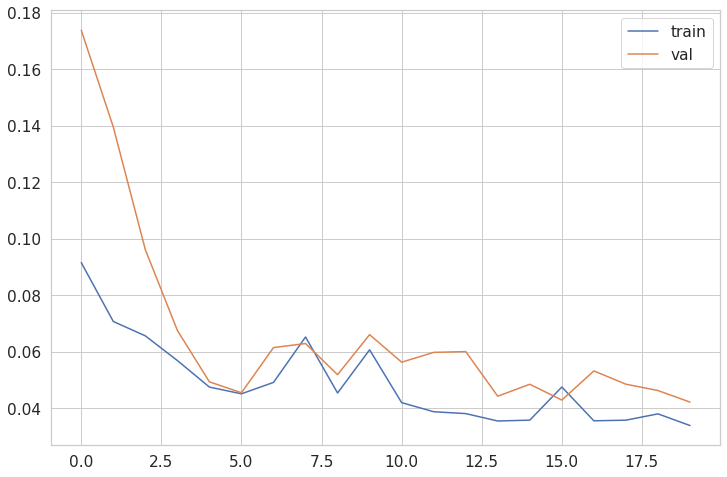

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_focal['train'], label="train")
plt.plot(losses_unet_focal['val'], label="val")
plt.legend()
plt.show()

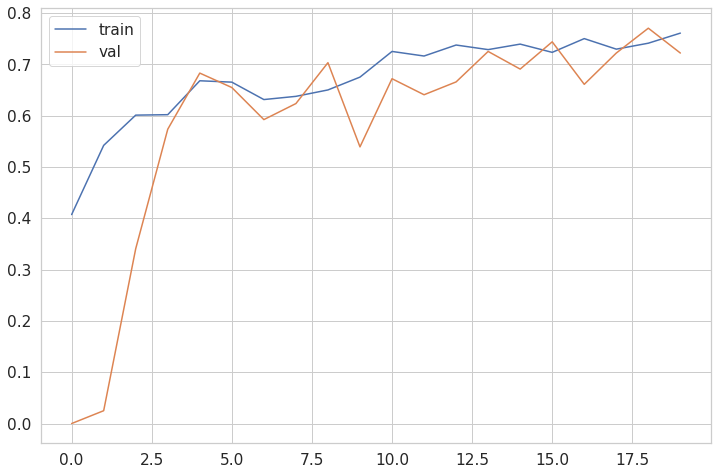

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_focal['train'], label="train")
plt.plot(metrics_unet_focal['val'], label="val")
plt.legend()
plt.show()

**UNET with Focal Loss on the test data**

In [ ]:
score_model(unet_focal, iou_pytorch, data_ts)

0.6921875327825546

**UNET + JACCARD**

In [ ]:
unet_jaccard = UNet().to(device)

In [ ]:
optimizer = optim.Adam(unet_jaccard.parameters(), lr=1e-4, weight_decay=0.00001)

In [ ]:
losses_unet_jaccard, metrics_unet_jaccard = train(unet_jaccard, optimizer, jaccard_loss, iou_pytorch, 20, data_tr, data_val)

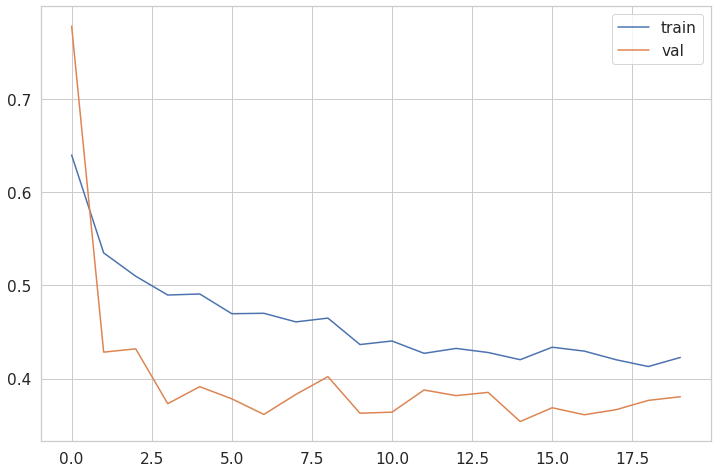

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_jaccard['train'], label="train")
plt.plot(losses_unet_jaccard['val'], label="val")
plt.legend()
plt.show()

**UNET with Jaccard Loss on the test data**

In [ ]:
score_model(unet_jaccard , iou_pytorch, data_ts)

0.6821428707667759

**UNET + Tversy Loss**

In [ ]:
unet_t = UNet().to(device)
optimizer = optim.Adam(unet_t.parameters(), lr=1e-4, weight_decay=0.00001)
losses_unet_t, metrics_unet_t = train(unet_t, optimizer, tversky_loss, iou_pytorch, 20, data_tr, data_val)

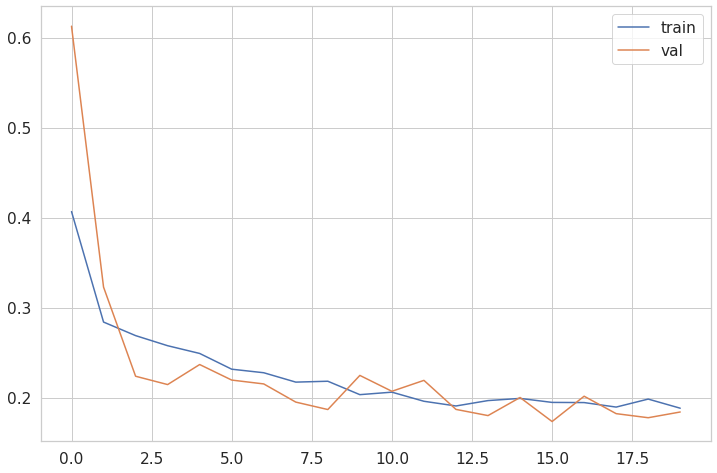

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_t['train'], label="train")
plt.plot(losses_unet_t['val'], label="val")
plt.legend()
plt.show()

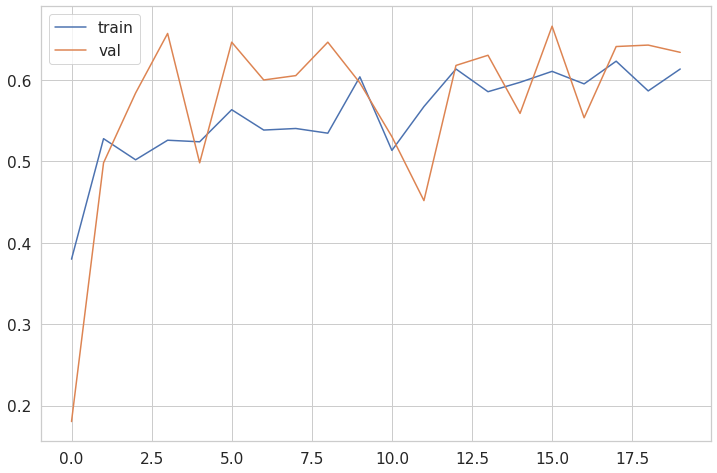

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_t['train'], label="train")
plt.plot(metrics_unet_t['val'], label="val")
plt.legend()
plt.show()

**UNET with Tversky Loss on the test data**

In [ ]:
score_model(unet_t, iou_pytorch, data_ts)

0.617857141154153

## UNET 2.0

Another version of  UNET with TransposeConvolution and convolutions with padding

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(
            kernel_size=2, stride=2
        ) 
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.pool1 = nn.MaxPool2d(
            kernel_size=2, stride=2
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.pool2 = nn.MaxPool2d(
            kernel_size=2, stride=2
        ) 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.pool3 = nn.MaxPool2d(
            kernel_size=2, stride=2
        ) 

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2) 
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) 
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2) 
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)  
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )
    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        #print(e0)
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))
        #print(e3.shape)

        # bottleneck
        b = self.bottleneck_conv(e3)
        #print(b.shape)

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat((d0, self.enc_conv3(e2)), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, self.enc_conv2(e1)), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, self.enc_conv1(e0)), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat((d3, self.enc_conv0(x)), dim=1)
        d3 = self.dec_conv3(d3)
        return d3 
    def crop(self, encoder, x):
        H, W = x.shape[2], x.shape[3]
        encoder = transforms.CenterCrop((H, W))(encoder)
        return encoder

**UNET_2 + BCE Loss**

In [ ]:
unet_model = UNet2().to(device)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=0.00001)
losses_unet_bce_2, metrics_unet_bce_2 = train(unet_model, optimizer, bce_loss, iou_pytorch, 20, data_tr, data_val)


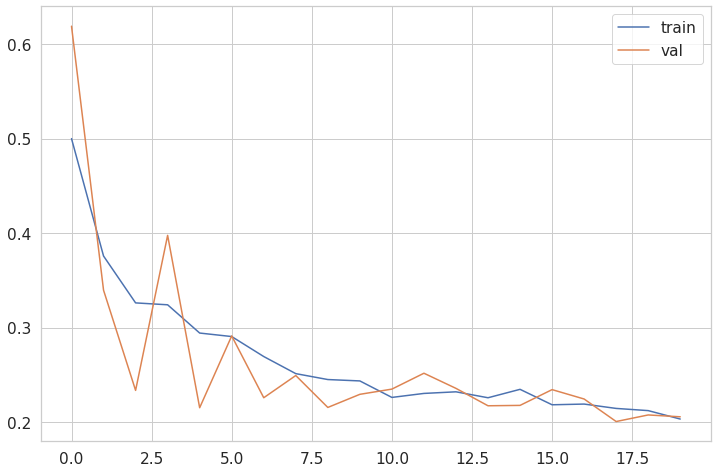

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_bce_2['train'], label="train")
plt.plot(losses_unet_bce_2['val'], label="val")
plt.legend()
plt.show()

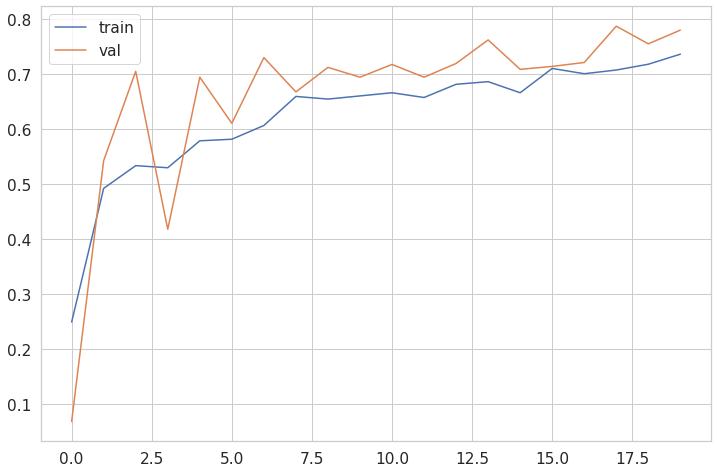

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_bce_2['train'], label="train")
plt.plot(metrics_unet_bce_2['val'], label="val")
plt.legend()
plt.show()

**UNET_2 with BCE loss on the test data**

In [ ]:
score_model(unet_model , iou_pytorch, data_ts)

0.7446428622518267

**UNET_2 + DICE Loss**

In [ ]:
unet_dice_2 = UNet2().to(device)
optimizer = optim.Adam(unet_dice_2.parameters(), lr=1e-4, weight_decay=0.00001)
losses_unet_dice, metrics_unet_dice = train(unet_dice_2, optimizer, dice_loss, iou_pytorch, 20, data_tr, data_val)

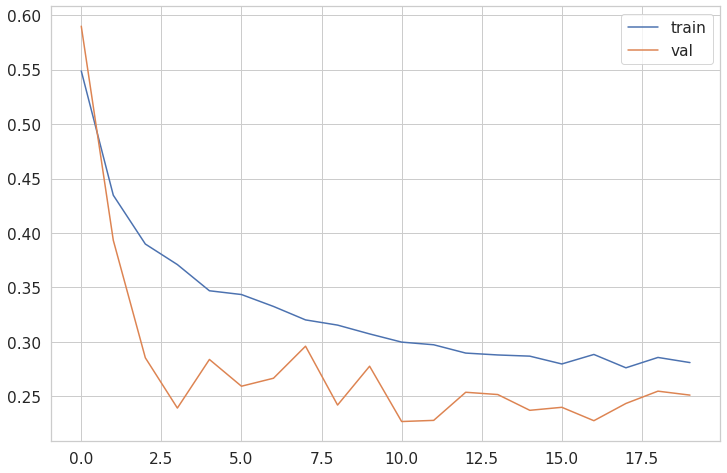

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_dice['train'], label="train")
plt.plot(losses_unet_dice['val'], label="val")
plt.legend()
plt.show()

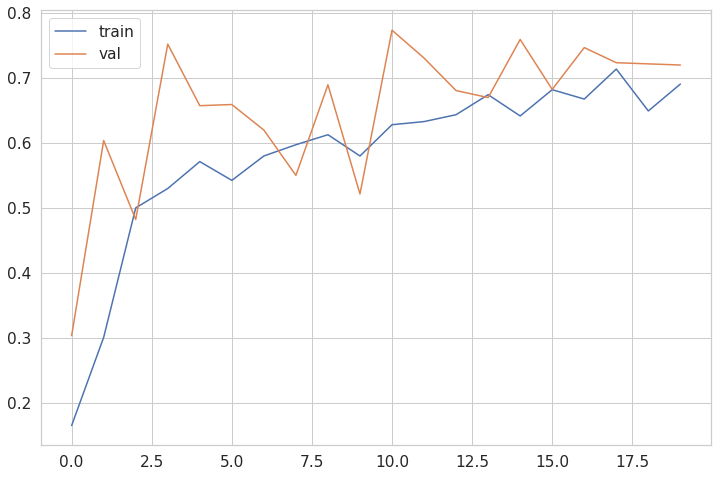

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_dice['train'], label="train")
plt.plot(metrics_unet_dice['val'], label="val")
plt.legend()
plt.show()

**UNET_2 with Dice loss on the test data**

In [ ]:
score_model(unet_dice_2 , iou_pytorch, data_ts)

0.7625000306538173

**UNET_2 + Focal Loss**

In [ ]:
unet_focal_2 = UNet2().to(device)
optimizer = optim.Adam(unet_focal_2.parameters(), lr=1e-4, weight_decay=0.00001)
losses_unet_focal_2, metrics_unet_focal_2 = train(unet_focal_2, optimizer, focal_loss, iou_pytorch, 20, data_tr, data_val)

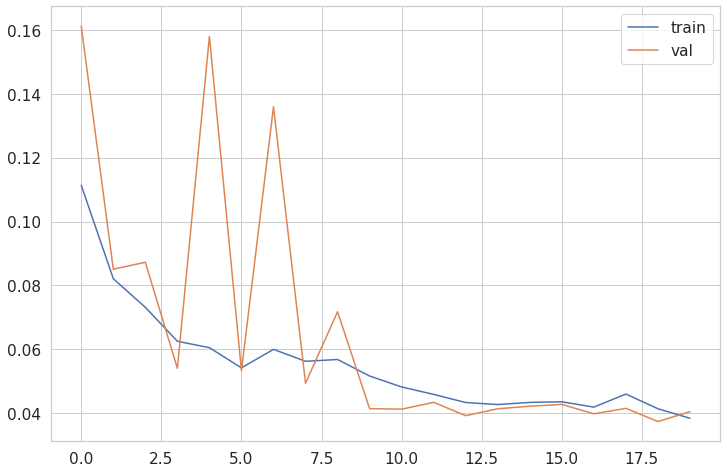

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_focal_2['train'], label="train")
plt.plot(losses_unet_focal_2['val'], label="val")
plt.legend()
plt.show()

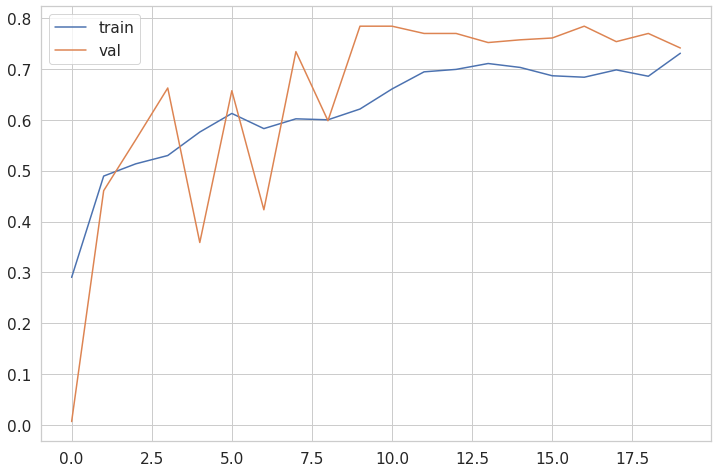

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_focal_2['train'], label="train")
plt.plot(metrics_unet_focal_2['val'], label="val")
plt.legend()
plt.show()

**UNET_2 with Focal loss on the test data**

In [ ]:
score_model(unet_focal_2 , iou_pytorch, data_ts)

0.7446428792817252

**UNET_2 + Jaccard Loss**

In [ ]:
unet_jaccard_2 = UNet2().to(device)
optimizer = optim.Adam(unet_jaccard_2.parameters(), lr=1e-4, weight_decay=0.00001)
losses_unet_jaccard_2, metrics_unet_jaccard_2 = train(unet_jaccard_2, optimizer, jaccard_loss, iou_pytorch, 20, data_tr, data_val)

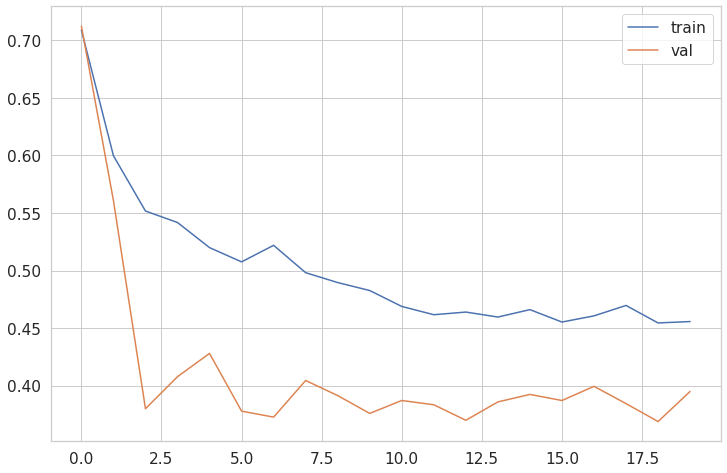

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_jaccard_2['train'], label="train")
plt.plot(losses_unet_jaccard_2['val'], label="val")
plt.legend()
plt.show()

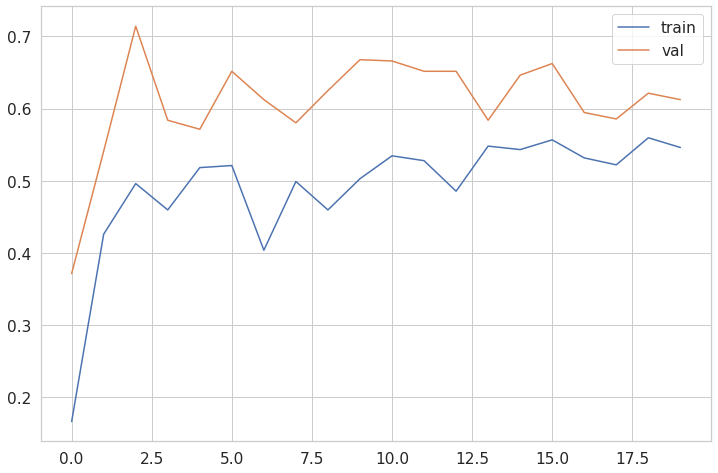

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_jaccard_2['train'], label="train")
plt.plot(metrics_unet_jaccard_2['val'], label="val")
plt.legend()
plt.show()

**UNET_2 c Jaccard лоссом на тестовой выборке**

In [ ]:
score_model(unet_jaccard_2 , iou_pytorch, data_ts)

0.6142857159887042

**UNET_2 + Tverskiy Loss**

In [ ]:
unet_t_2 = UNet2().to(device)
optimizer = optim.Adam(unet_t_2.parameters(), lr=1e-4, weight_decay=0.00001)
losses_unet_t_2, metrics_unet_t_2 = train(unet_t_2, optimizer, tversky_loss, iou_pytorch, 20, data_tr, data_val)

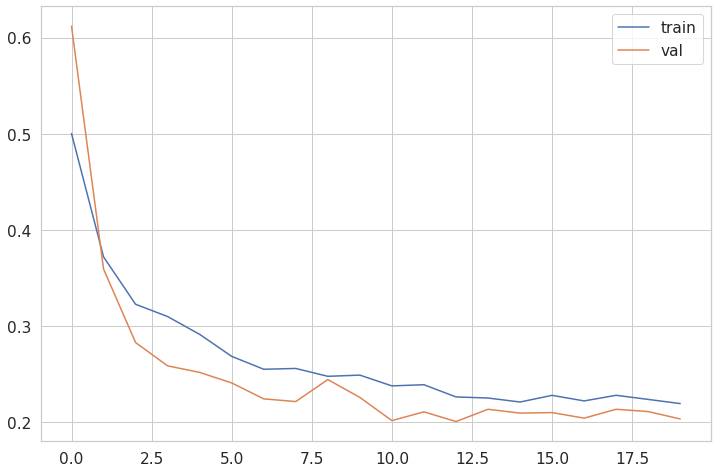

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses_unet_t_2['train'], label="train")
plt.plot(losses_unet_t_2['val'], label="val")
plt.legend()
plt.show()

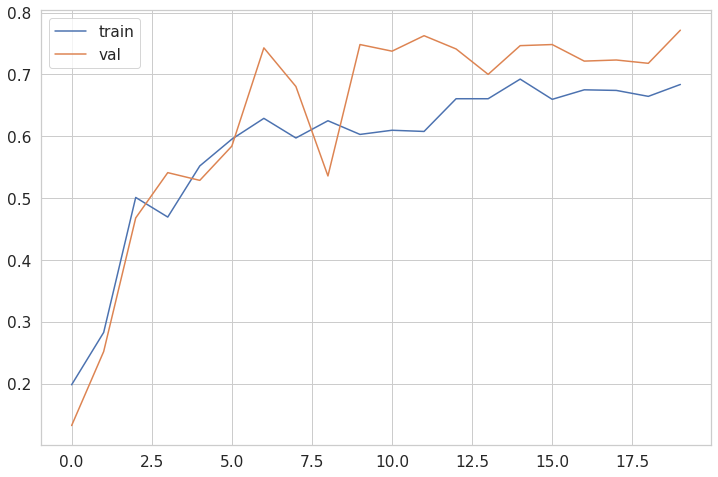

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_unet_t_2['train'], label="train")
plt.plot(metrics_unet_t_2['val'], label="val")
plt.legend()
plt.show()

**UNET_2 with Tverksky loss on the test data**

In [ ]:
score_model(unet_t_2, iou_pytorch, data_ts)

0.6767857330186027

## Report

**1. SEGNET with BCE Loss, Dice Loss, Focal Loss and Jaccard Loss**

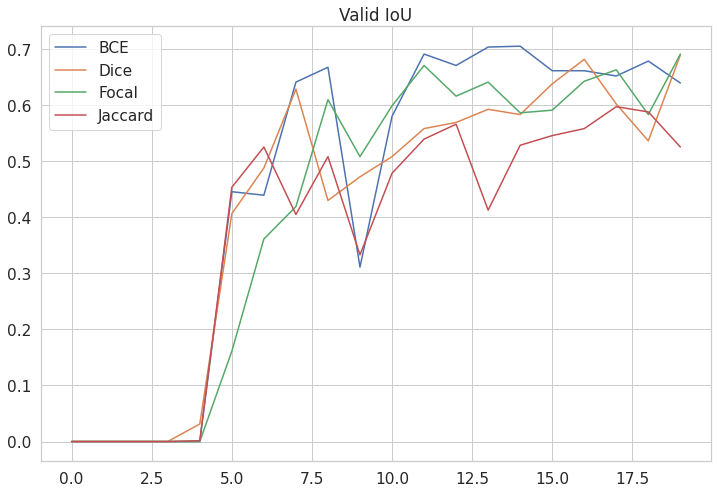

In [ ]:
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.title('Valid IoU')
plt.plot(metrics_segnet_bse['val'], label="BCE")
plt.plot(metrics_segnet_dice['val'], label='Dice')
plt.plot(metrics_segnet_focal['val'], label='Focal')
plt.plot(metrics_segnet_jaccard['val'], label='Jaccard')
plt.legend()
plt.show()

Thus, from the graphs of the dependence of the IoU metric on the number of epochs for various loss functions, it can be seen that at the first stages of training (about 5 epochs), the metric for all loss functions is equal to zero. Then BCE starts showing itself best and reaches its maximum equal to 0.7. However, after epoch 16, overfitting takes place, and at the end of training, the value of the metric for BCE becomes about 0.65. By the end of training for 20 epochs, the Dice and Focal loss functions were best.

IoU on the test data: \
**1) BCE: 0.7344** \
2) Dice: 0.7219 \
3) Focal: 0.6578 \
4) Jaccard: 0.7063 \
The best model is model with BCE loss

**2. UNET with BCE Loss, Dice Loss, Focal Loss and Jaccard Loss**

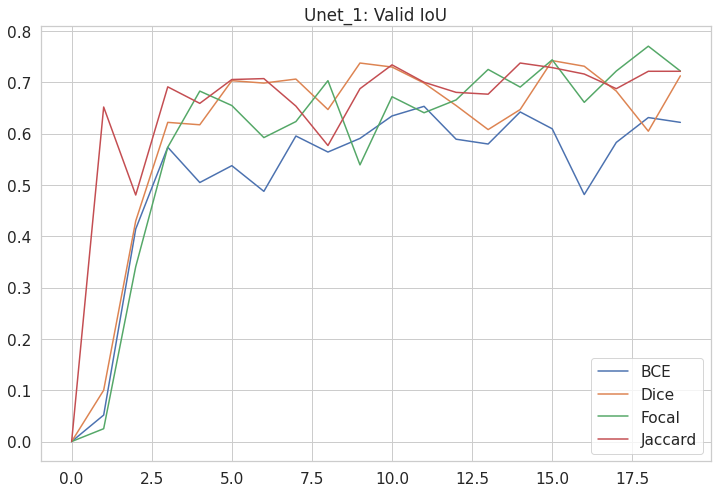

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Unet_1: Valid IoU')
plt.plot(unet_bce['val'], label="BCE")
plt.plot(unet_dice['val'], label='Dice')
plt.plot(unet_focal['val'], label='Focal')
plt.plot(unet_jaccard['val'], label='Jaccard')
plt.legend()
plt.show()

On the validation set, the model with Jaccard learns faster at the initial epochs and reaches a value greater than 0.7 by the end of training. The model with Focal loss also trains well, and by the end of the training it also reaches the value of 0.7

IoU on the test data: \
**1) BCE: 0.7422** \
2) Dice: 0.7219 \
3) Focal: 0.6922 \
4) Jaccard: 0.6821 \
Despite the fact that on the validation set the model with BCE loss was the worst, on the test set Unet with BCE loss shows the best result 

**3. UNET_2 with BCE Loss, Dice Loss, Focal Loss and Jaccard Loss**


When training this version of UNet, the batch size was 8, because of the lack of memory on GPU

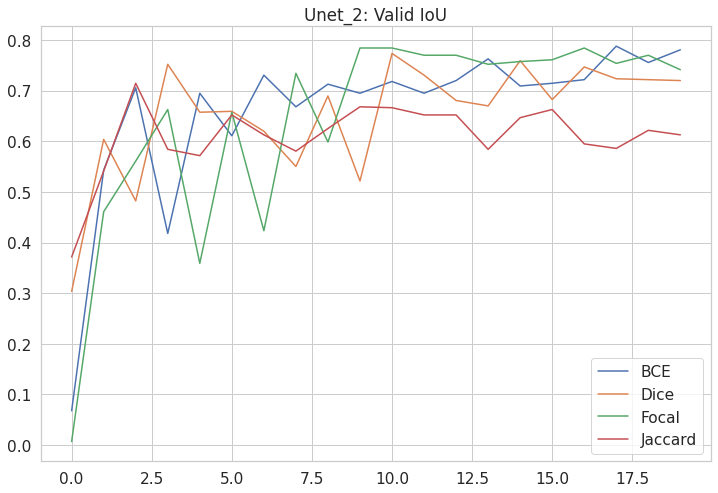

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Unet_2: Valid IoU')
plt.plot(metrics_unet_bce_2['val'], label="BCE")
plt.plot(metrics_unet_dice['val'], label='Dice')
plt.plot(metrics_unet_focal_2['val'], label='Focal')
plt.plot(metrics_unet_jaccard_2['val'], label='Jaccard')
plt.legend()
plt.show()

Models with BCE and Focal losses perform best on the validation set. BCE reaches ~0.8 by the end of training.

IoU on the test data:: \
1) BCE: 0.7446 \
**2) Dice: 0.7625** \
3) Focal: 0.7446 \
4) Jaccard: 0.6143 \
The best model is the model with Dice

### **Comparison of models with corresponding losses**




**1. BCE Loss:**

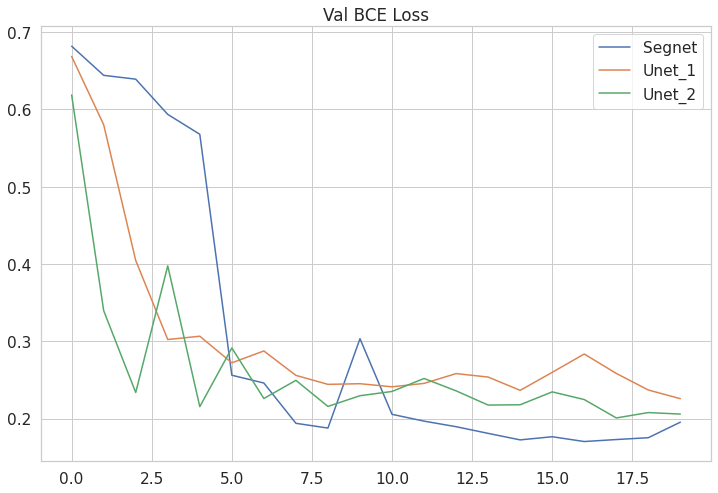

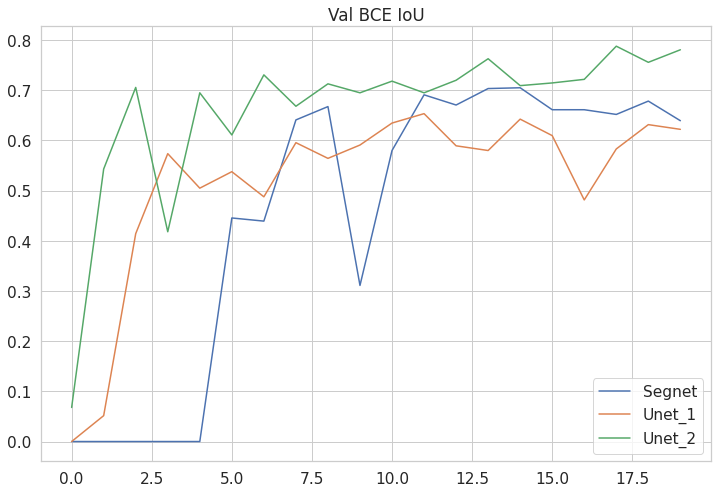

**2. DICE Loss:**

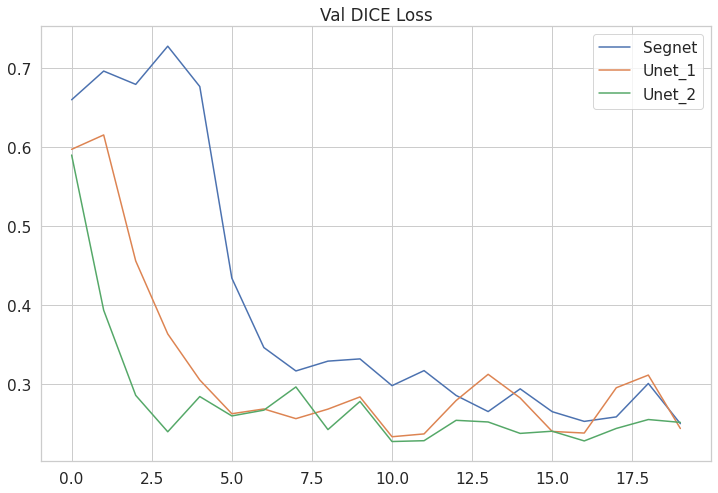

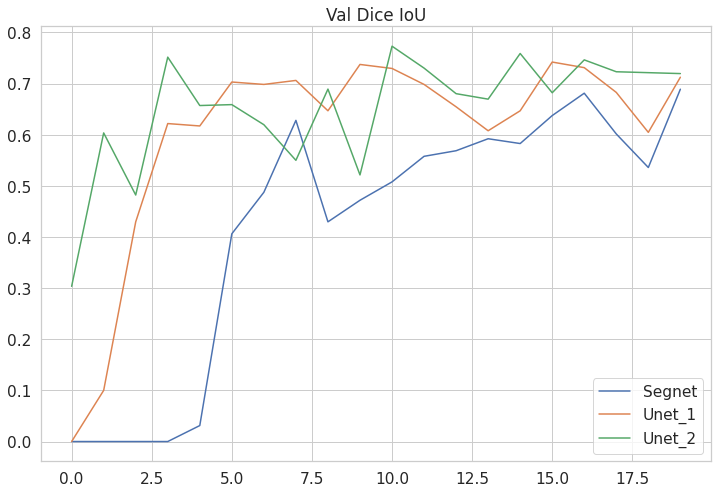

**3. Focal Loss:**


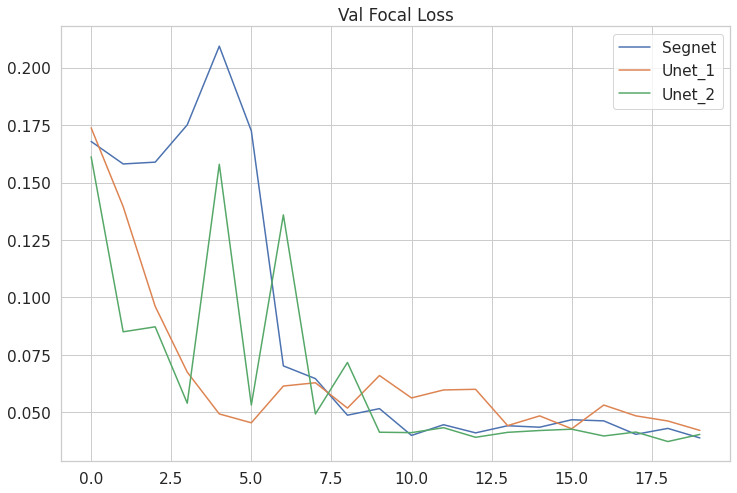

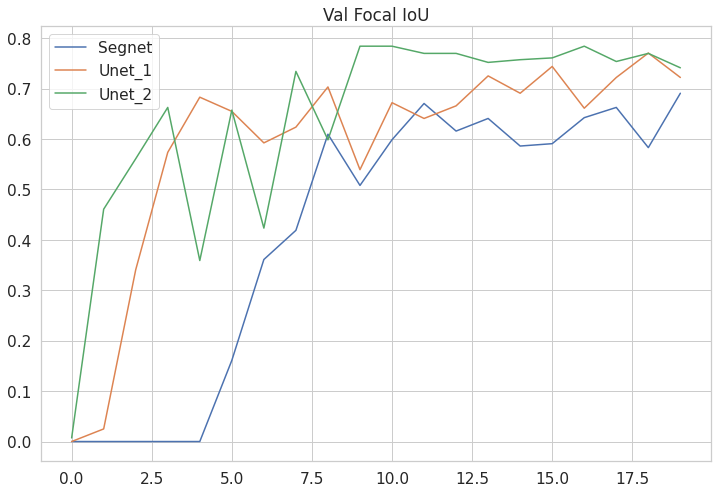

**4. Jaccard Loss:**

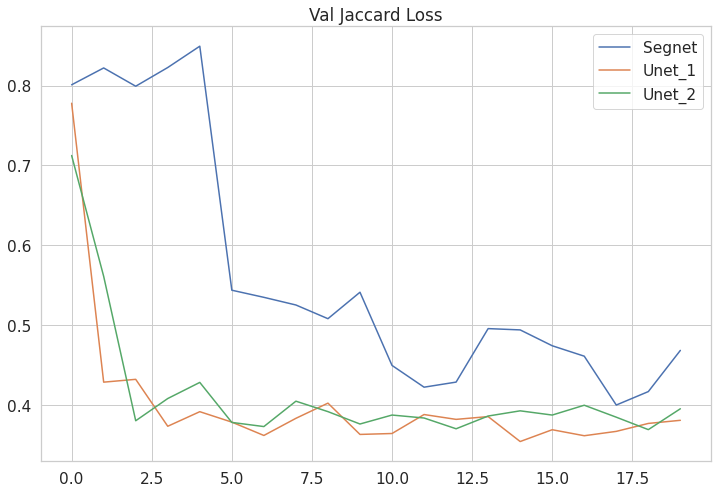

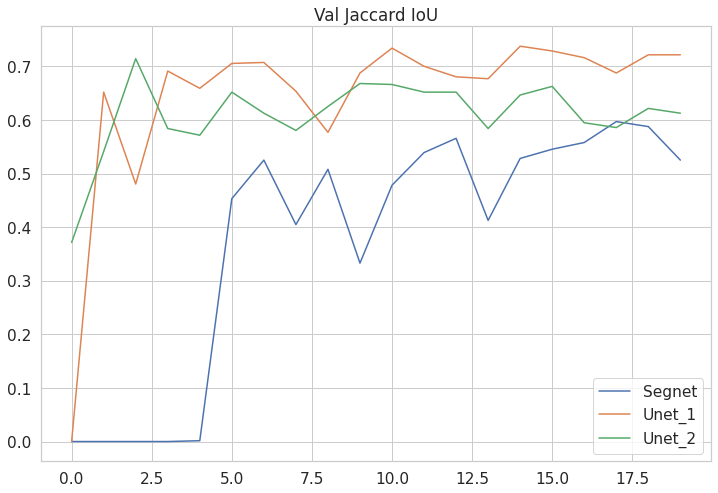

## Conclusion

Thus, models for semantic segmentation of SegNet and Unet were implemented
Unet has been implemented in two ways:\
1) Unet_1 - the Upsample function was used as an upsamling, there were no paddings in the convolutional layers. \
2) Unet_2 - the TransposeConvolution function was used as an upsamling, padding = 1 was used in convolutional layers.

Models with different loss functions were compared: BCE Loss, Dice Loss, Focal Loss and Jaccard Loss. From the plots of loss functions and IoU metrics, we can conclude that both implementations of Unet on the validation set perform better than SegNet: loss functions converge faster, IoU metrics reach higher values, and the models themselves are less prone to overfitting.

Among Unet, the second implementation of Unet_2 turned out to be the best, since it, thanks to the use of convolutions in paddings, does not reduce strongly the size of the input image. Therefore, it results in less information loss.

Among all the models tested in this work, Unet_2 is a winner. Loss functions converge faster, the model is the least prone to overfitting. On the validation and test sets, Unet_2 also performed best for all loss functions except for the Jaccard loss.